
# Projet de Prétraitement des Données – Maladie Cardiaque UCI

Ce notebook présente un **projet de prétraitement de données** appliqué au jeu de données *UCI Heart Disease* disponible sur Kaggle. L’objectif est de mettre en pratique les méthodes étudiées en cours : traitement des valeurs manquantes, encodage des variables catégorielles, normalisation/standardisation et RobustScaler, discrétisation, transformations avancées (PowerTransformer et PolynomialFeatures) et construction de **pipelines**.

Nous commencerons par une exploration du jeu de données, suivie de la préparation des colonnes numériques et catégorielles, puis nous appliquerons les différentes techniques de prétraitement et comparerons un modèle de classification.


In [147]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import skew

# Charger les données
path = 'heart_disease_uci.csv'
df = pd.read_csv(path)
# Afficher un aperçu
df.head()


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



## Partie 1 : Exploration des données

Commençons par explorer la taille, les types et les valeurs manquantes du jeu de données. Un bon prétraitement est essentiel pour assurer la qualité des données et améliorer les performances des modèles de machine learning. Les cours rappellent que le prétraitement consiste à transformer les données brutes en un format approprié pour l’apprentissage, en corrigeant les anomalies et en assurant la compatibilité entre les variables【314948406165233†L195-L286】.


In [149]:
# Dimensions et informations générales
print(f"Nombre d'observations : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")

Nombre d'observations : 920
Nombre de colonnes : 16


In [150]:
print('Types de colonnes:')
print(df.dtypes)

Types de colonnes:
id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object


In [151]:
# Nombre de valeurs manquantes par colonne
missing = df.isnull().sum()
print('Valeurs manquantes par colonne:')
print(missing)

Valeurs manquantes par colonne:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


In [152]:
# Afficher l'information détaillée
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB



## Partie 2 : Sélection des colonnes

Pour appliquer les bonnes transformations, nous devons distinguer les colonnes **numériques** et **catégorielles** :

* **Colonnes numériques :** `age`, `trestbps`, `chol`, `thalch`, `oldpeak`, `ca` (ainsi que `id` mais qui sert d’identifiant et n’est pas utilisé pour l’entraînement). Ces variables sont continues ou discrètes et peuvent être normalisées ou standardisées.
* **Colonnes catégorielles :** `sex`, `dataset`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `thal` et `num` (cette dernière est la cible). Elles contiennent des catégories nominales ou ordinales.

Certaines variables peuvent avoir un ordre naturel : par exemple `slope` avec les valeurs *downsloping*, *flat* et *upsloping* peut être considérée comme ordinale. Le type de variable détermine la méthode d’encodage : les **encodeurs ordinaux** produisent un entier pour chaque catégorie et sont adaptés aux variables ordinales, tandis que l’**One‑Hot Encoding** crée une colonne binaire pour chaque niveau, ce qui convient aux variables nominales【164728873141510†L682-L696】.


In [154]:

# Définir les colonnes numériques et catégorielles
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
# on peut éliminer 'id' car c'est un identifiant
categorical_features = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
target = 'num'


In [155]:
counts = df["num"].value_counts(dropna=False)
props = df["num"].value_counts(normalize=True, dropna=False) * 100

print("Effectifs par classe :")
print(counts)
print("\nPourcentages par classe :")
print(props.round(2))

Effectifs par classe :
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Pourcentages par classe :
num
0    44.67
1    28.80
2    11.85
3    11.63
4     3.04
Name: proportion, dtype: float64



## Partie 3 : Imputation des valeurs manquantes

Les valeurs manquantes peuvent être imputées de plusieurs manières. **SimpleImputer** remplace les valeurs manquantes par une statistique (moyenne, médiane, valeur la plus fréquente ou constante)【943916530225596†L677-L715】. **KNNImputer** utilise les *k* plus proches voisins pour estimer les valeurs manquantes en se basant sur la similarité des autres variables【817569637401409†L681-L715】.

Nous appliquerons différentes stratégies pour les colonnes numériques et catégorielles et comparerons les résultats. Pour les variables numériques, les stratégies courantes sont la moyenne et la médiane. Pour les variables catégorielles, on utilise généralement la catégorie la plus fréquente ou une valeur constante.


In [157]:
# 1) Séparation des caractéristiques et de la cible
X = df[numeric_features + categorical_features]
y = df[target]

# 2) Imputation simple : moyenne pour les numériques, valeur la plus fréquente pour les catégoriques
numeric_imputer_mean   = SimpleImputer(strategy="mean")
numeric_imputer_median = SimpleImputer(strategy="median")
categorical_imputer_mode = SimpleImputer(strategy="most_frequent")

# =========================
# A) COMPARAISON (pour analyse)
# =========================
# Appliquer l'imputation sur des copies pour comparaison

# A1) Mean
X_mean_imputed = X.copy()
X_mean_imputed[numeric_features] = numeric_imputer_mean.fit_transform(X[numeric_features])
X_mean_imputed[categorical_features] = categorical_imputer_mode.fit_transform(X[categorical_features])

# A2) Median
X_median_imputed = X.copy()
X_median_imputed[numeric_features] = numeric_imputer_median.fit_transform(X[numeric_features])
X_median_imputed[categorical_features] = categorical_imputer_mode.fit_transform(X[categorical_features])

# A3)  Imputation KNN : on ne peut l'appliquer qu'aux colonnes numériques. Les colonnes catégorielles sont encodées préalablement.
# OrdinalEncoder pour KNN (ordre arbitraire)
ord_encoder_knn = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_ord = X.copy()
X_ord[categorical_features] = ord_encoder_knn.fit_transform(X[categorical_features])

knn_imputer = KNNImputer(n_neighbors=5)
X_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(X_ord), columns=X_ord.columns)

# Restaurer les colonnes catégorielles en texte à l'aide de l'encodeur ordinal inverse
X_knn_imputed[categorical_features] = ord_encoder_knn.inverse_transform(X_knn_imputed[categorical_features])

print("Imputation simple (moyenne) - premières lignes :")
display(X_mean_imputed.head())

print("Imputation simple (médiane) - premières lignes :")
display(X_median_imputed.head())

print("Imputation KNN - premières lignes :")
display(X_knn_imputed.head())

Imputation simple (moyenne) - premières lignes :


,age,trestbps,chol,thalch,oldpeak,ca,sex,dataset,cp,fbs,restecg,exang,slope,thal
0,63.0,145.0,233.0,150.0,2.3,0.0,Male,Cleveland,typical angina,True,lv hypertrophy,False,downsloping,fixed defect
1,67.0,160.0,286.0,108.0,1.5,3.0,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,normal
2,67.0,120.0,229.0,129.0,2.6,2.0,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,reversable defect
3,37.0,130.0,250.0,187.0,3.5,0.0,Male,Cleveland,non-anginal,False,normal,False,downsloping,normal
4,41.0,130.0,204.0,172.0,1.4,0.0,Female,Cleveland,atypical angina,False,lv hypertrophy,False,upsloping,normal


Imputation simple (médiane) - premières lignes :


,age,trestbps,chol,thalch,oldpeak,ca,sex,dataset,cp,fbs,restecg,exang,slope,thal
0,63.0,145.0,233.0,150.0,2.3,0.0,Male,Cleveland,typical angina,True,lv hypertrophy,False,downsloping,fixed defect
1,67.0,160.0,286.0,108.0,1.5,3.0,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,normal
2,67.0,120.0,229.0,129.0,2.6,2.0,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,reversable defect
3,37.0,130.0,250.0,187.0,3.5,0.0,Male,Cleveland,non-anginal,False,normal,False,downsloping,normal
4,41.0,130.0,204.0,172.0,1.4,0.0,Female,Cleveland,atypical angina,False,lv hypertrophy,False,upsloping,normal


Imputation KNN - premières lignes :


,age,trestbps,chol,thalch,oldpeak,ca,sex,dataset,cp,fbs,restecg,exang,slope,thal
0,63.0,145.0,233.0,150.0,2.3,0.0,Male,Cleveland,typical angina,True,lv hypertrophy,False,downsloping,fixed defect
1,67.0,160.0,286.0,108.0,1.5,3.0,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,normal
2,67.0,120.0,229.0,129.0,2.6,2.0,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,reversable defect
3,37.0,130.0,250.0,187.0,3.5,0.0,Male,Cleveland,non-anginal,False,normal,False,downsloping,normal
4,41.0,130.0,204.0,172.0,1.4,0.0,Female,Cleveland,atypical angina,False,lv hypertrophy,False,upsloping,normal


In [158]:
# =========================
# B) APPLICATION REELLE (choix final)
# =========================
# Choix du projet : médiane (num) + mode (cat)

X_imputed = X.copy()

# Fit sur les vraies données puis transform => données finales propres
X_imputed[numeric_features] = numeric_imputer_median.fit_transform(X[numeric_features])
X_imputed[categorical_features] = categorical_imputer_mode.fit_transform(X[categorical_features])

print("✅ Données finales après imputation choisie (médiane + mode) :")
display(X_imputed.head())

# Vérification : plus de NaN
print("✅ Valeurs manquantes restantes après imputation :")
print(X_imputed.isna().sum().sort_values(ascending=False).head(10))

✅ Données finales après imputation choisie (médiane + mode) :


,age,trestbps,chol,thalch,oldpeak,ca,sex,dataset,cp,fbs,restecg,exang,slope,thal
0,63.0,145.0,233.0,150.0,2.3,0.0,Male,Cleveland,typical angina,True,lv hypertrophy,False,downsloping,fixed defect
1,67.0,160.0,286.0,108.0,1.5,3.0,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,normal
2,67.0,120.0,229.0,129.0,2.6,2.0,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,reversable defect
3,37.0,130.0,250.0,187.0,3.5,0.0,Male,Cleveland,non-anginal,False,normal,False,downsloping,normal
4,41.0,130.0,204.0,172.0,1.4,0.0,Female,Cleveland,atypical angina,False,lv hypertrophy,False,upsloping,normal


✅ Valeurs manquantes restantes après imputation :
age         0
trestbps    0
chol        0
thalch      0
oldpeak     0
ca          0
sex         0
dataset     0
cp          0
fbs         0
dtype: int64



**Comparaison des méthodes d’imputation :**

- **SimpleImputer (moyenne/médiane)** remplace les valeurs manquantes par une statistique unique calculée sur la colonne. La moyenne est sensible aux valeurs extrêmes alors que la médiane est plus robuste. L’imputation de la catégorie la plus fréquente est utilisée pour les variables catégorielles car elle est simple et conserve des valeurs plausibles.
- **KNNImputer** estime les valeurs manquantes en utilisant la moyenne des valeurs des *k* plus proches voisins (basés sur les autres variables). Cette méthode peut capturer des relations plus complexes entre les variables mais elle est plus coûteuse en temps de calcul et peut être sensible au choix du nombre de voisins【817569637401409†L681-L715】.

Dans ce projet, nous choisirons la **médiane** pour les variables numériques car elle est moins affectée par les outliers, et la **valeur la plus fréquente** pour les variables catégorielles. Le KNNImputer sera utilisé en complément pour vérifier l’impact de cette approche.



## Partie 4 : Encodage des variables catégorielles

Les modèles de machine learning exigent des entrées **numériques**. Après l’imputation (`X_imputed`), on encode donc les variables catégorielles selon leur nature :

- **`slope`** est considérée **ordinale** (downsloping < flat < upsloping) : on applique `OrdinalEncoder` pour obtenir une variable numérique `slope_ord`.
- Les autres variables catégorielles sont **nominales** : on applique `OneHotEncoder` afin de créer des colonnes binaires (avec `drop='first'` pour éviter la redondance, et `handle_unknown='ignore'` pour gérer d’éventuelles catégories non vues).

Enfin, on **concatène** les variables numériques + `slope_ord` + les colonnes one-hot dans `encoded_df`, prêt pour la modélisation.



In [161]:
# Encodage sur les données imputées (pas sur df)
df_enc_example = X_imputed.copy()

# Colonne ordinale
ordinal_cols = ['slope']
slope_categories = [['downsloping', 'flat', 'upsloping']]
ord_enc = OrdinalEncoder(categories=slope_categories)

df_enc_example['slope_ord'] = ord_enc.fit_transform(X_imputed[['slope']])

# Colonnes nominales = toutes les catégorielles sauf slope
nominal_cols = [col for col in categorical_features if col not in ordinal_cols]

# OneHotEncoder (scikit-learn récent)
onehot_enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

nominal_encoded = onehot_enc.fit_transform(X_imputed[nominal_cols])
nominal_encoded_df = pd.DataFrame(
    nominal_encoded,
    columns=onehot_enc.get_feature_names_out(nominal_cols),
    index=X_imputed.index
)

# Concaténer : numériques + slope_ord + onehot nominal
encoded_df = pd.concat(
    [X_imputed[numeric_features].copy(), df_enc_example[['slope_ord']], nominal_encoded_df],
    axis=1
)

display(encoded_df.head(20))


,age,trestbps,chol,thalch,oldpeak,ca,slope_ord,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,thal_normal,thal_reversable defect
0,63.0,145.0,233.0,150.0,2.3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,67.0,160.0,286.0,108.0,1.5,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,67.0,120.0,229.0,129.0,2.6,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,37.0,130.0,250.0,187.0,3.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,41.0,130.0,204.0,172.0,1.4,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,56.0,120.0,236.0,178.0,0.8,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,62.0,140.0,268.0,160.0,3.6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,57.0,120.0,354.0,163.0,0.6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
8,63.0,130.0,254.0,147.0,1.4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,53.0,140.0,203.0,155.0,3.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0



### Conclusion / Interprétation (Encodage)

Le tableau obtenu confirme que l’encodage a bien été réalisé :  
- `slope` est transformée en **une seule variable ordinale** (`slope_ord`), ce qui préserve l’ordre naturel des catégories.  
- Les autres variables catégorielles sont converties en **colonnes binaires (0/1)** via le **One-Hot Encoding**, ce qui évite d’imposer un ordre artificiel.  

Ainsi, toutes les variables deviennent **numériques** et directement exploitables par les modèles de machine learning, tout en conservant l’information portée par les catégories.


## Partie 5 — Discrétisation de `age` (KBinsDiscretizer)

Dans cette étape, on transforme la variable continue `age` en **intervalles (bins)** à l’aide de `KBinsDiscretizer`.  
On choisit **4 bins** (`n_bins=4`) avec la stratégie **uniform** (bins de largeur égale) et un encodage **ordinal** (`encode="ordinal"`), ce qui attribue à chaque observation un numéro de bin (0, 1, 2, 3).  

On utilise `X_imputed` pour éviter les valeurs manquantes, puis on affiche :
- les **bornes des bins** (`bin_edges_`),
- la **répartition** des observations par bin,
- un aperçu **avant/après** et un **graphique comparatif**.



✅ age - bin_edges_ (uniform, n_bins=4) : [28.   40.25 52.5  64.75 77.  ]
✅ Répartition par bin :
age_bin
0     93
1    295
2    429
3    103
Name: count, dtype: int64


,age,age_bin
0,63.0,2
1,67.0,3
2,67.0,3
3,37.0,0
4,41.0,1
5,56.0,2
6,62.0,2
7,57.0,2
8,63.0,2
9,53.0,2


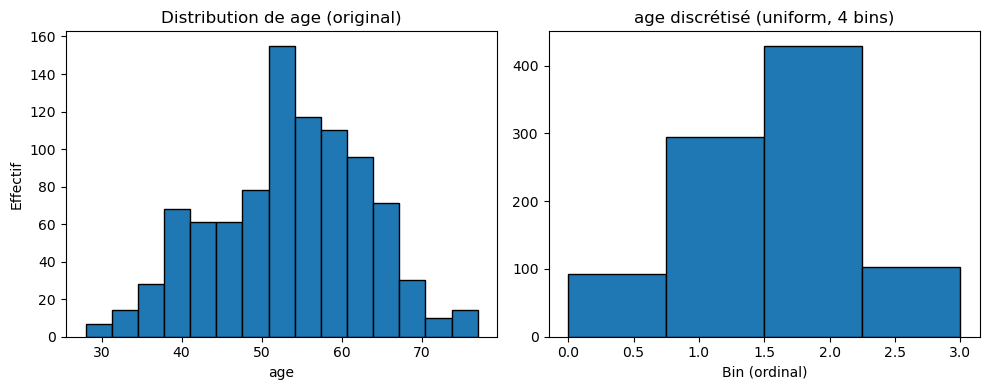

In [164]:
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Partie 5 : Discrétisation (AGE) avec KBinsDiscretizer
# -----------------------------

var = "age"
n_bins = 4                  # 3 ou 4 selon la consigne
strategy = "uniform"        # uniform / quantile / kmeans
encode_mode = "ordinal"     # 'ordinal' ou 'onehot'

# ✅ Utiliser les données imputées (cohérence + pas de NaN)
age_values = X_imputed[[var]].values

kbin = KBinsDiscretizer(
    n_bins=n_bins,
    encode=encode_mode,
    strategy=strategy
)

age_binned = kbin.fit_transform(age_values)

# Si encode='ordinal', on peut convertir en int facilement pour compter
if encode_mode == "ordinal":
    age_bins_int = age_binned.astype(int).ravel()
else:
    age_bins_int = None  # onehot -> pas un seul numéro de bin

# ✅ Bornes des bins (très demandé dans les rapports)
bin_edges = kbin.bin_edges_[0]
print(f"✅ {var} - bin_edges_ ({strategy}, n_bins={n_bins}) : {bin_edges}")

# ✅ Répartition des bins
if encode_mode == "ordinal":
    print("✅ Répartition par bin :")
    print(pd.Series(age_bins_int, name=f"{var}_bin").value_counts().sort_index())
else:
    print("✅ encode='onehot' -> répartition possible via somme des colonnes :")
    # age_binned est une matrice onehot, chaque colonne = un bin
    # somme par colonne = effectif du bin
    counts = age_binned.sum(axis=0)
    # si sparse matrix
    if hasattr(counts, "A1"):
        counts = counts.A1
    print(pd.Series(counts, index=[f"bin_{i}" for i in range(n_bins)]))

# ✅ Tableau avant/après (utile pour le rapport)
df_age_bins = pd.DataFrame({var: age_values.ravel()})
if encode_mode == "ordinal":
    df_age_bins[f"{var}_bin"] = age_bins_int
display(df_age_bins.head(10))

# ✅ Graphique comparatif avant/après
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(age_values.ravel(), bins=15, edgecolor="k")
plt.title(f"Distribution de {var} (original)")
plt.xlabel(var)
plt.ylabel("Effectif")

plt.subplot(1,2,2)
if encode_mode == "ordinal":
    plt.hist(age_bins_int, bins=n_bins, edgecolor="k")
    plt.title(f"{var} discrétisé ({strategy}, {n_bins} bins)")
    plt.xlabel("Bin (ordinal)")
else:
    # en onehot, on affiche les effectifs par bin
    counts = age_binned.sum(axis=0)
    if hasattr(counts, "A1"):
        counts = counts.A1
    plt.bar(range(n_bins), counts)
    plt.title(f"{var} discrétisé ONEHOT ({strategy}, {n_bins} bins)")
    plt.xlabel("Bin")
    plt.ylabel("Effectif")

plt.tight_layout()
plt.show()



La stratégie uniform découpe l’âge en intervalles de largeur égale. Les bin_edges_ donnent les limites exactes, et la table des effectifs montre si les bins sont équilibrés ou non. Le choix de n_bins et de la stratégie influence la représentation des données et peut impacter le modèle.


## Partie 5 suite : Discrétisation par similarité (KMeans) sur chol
On applique aussi kmeans sur chol pour créer des bins par similarité. Contrairement à uniform (largeur fixe), kmeans regroupe des valeurs proches afin de former des niveaux de cholestérol plus “naturels” (bas/moyen/élevé).

 Bornes des bins (kmeans) : [  0.         108.62424506 261.06292378 603.        ]
Répartition par bin :
0    175
1    492
2    253
Name: count, dtype: int64


,chol,chol_bin_kmeans
0,233.0,1
1,286.0,2
2,229.0,1
3,250.0,1
4,204.0,1
5,236.0,1
6,268.0,2
7,354.0,2
8,254.0,1
9,203.0,1


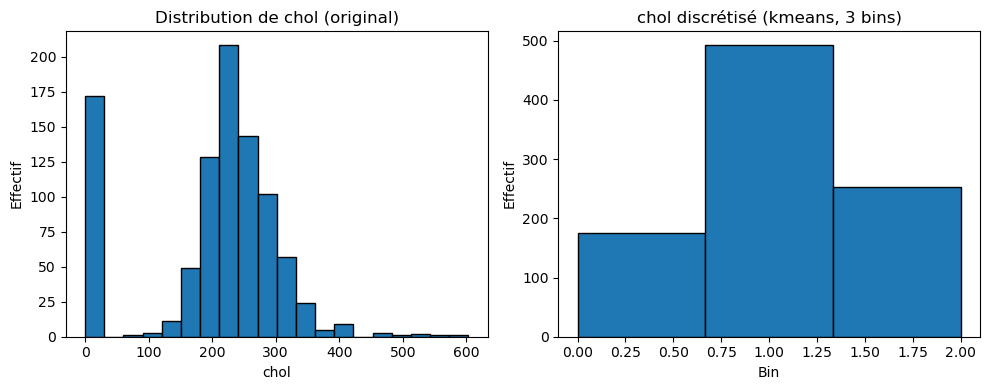

In [167]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Exemple 2 : KBinsDiscretizer (strategy="kmeans") sur chol
# -----------------------------

var = "chol"          # variable continue pertinente
n_bins = 3           

# Utiliser les données imputées (X_imputed)

chol_values = X_imputed[[var]].values   


kbin_kmeans = KBinsDiscretizer(
    n_bins=n_bins,
    encode="ordinal",       # ou "onehot"
    strategy="kmeans"
)

chol_binned = kbin_kmeans.fit_transform(chol_values).astype(int).ravel()

# bornes des bins (edges)
bin_edges = kbin_kmeans.bin_edges_[0]

print(" Bornes des bins (kmeans) :", bin_edges)
print("Répartition par bin :")
print(pd.Series(chol_binned).value_counts().sort_index())

# Tableau avant/après
df_kmeans_bins = pd.DataFrame({
    var: chol_values.ravel(),
    f"{var}_bin_kmeans": chol_binned
})

display(df_kmeans_bins.head(10))

# Graphique comparatif avant/après
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(chol_values.ravel(), bins=20, edgecolor="k")
plt.title(f"Distribution de {var} (original)")
plt.xlabel(var)
plt.ylabel("Effectif")

plt.subplot(1,2,2)
plt.hist(chol_binned, bins=n_bins, edgecolor="k")
plt.title(f"{var} discrétisé (kmeans, {n_bins} bins)")
plt.xlabel("Bin")
plt.ylabel("Effectif")

plt.tight_layout()
plt.show()


Les bin_edges_ indiquent les seuils entre les groupes détectés, et la répartition par bin montre la taille de chaque groupe. Cette discrétisation suit mieux la structure des données que uniform lorsque chol présente des regroupements, mais n_bins doit rester raisonnable pour éviter une perte d’info ou des bins instables.

uniform : découpe en intervalles égaux (simple mais pas “data-driven”)

quantile : bins avec le même nombre d’exemples (utile si distribution asymétrique)

✅ kmeans : bins créés par similarité (regroupe les valeurs proches en minimisant la variance intra-bin), donc c’est très cohérent avec l’idée de “niveaux” de cholestérol/tension.


## Partie 6 : Normalisation et Standardisation

Les techniques de mise à l’échelle transforment les variables pour qu’elles aient des propriétés comparables :

* **MinMaxScaler** applique une transformation linéaire pour rescaler les données entre 0 et 1 (ou un intervalle choisi), mais ne réduit pas l’influence des valeurs extrêmes.
* **StandardScaler** standardise les données en leur donnant une moyenne nulle et un écart‑type égal à 1.
* **RobustScaler** utilise la médiane et l’intervalle interquartile (IQR) pour centrer et mettre à l’échelle, ce qui le rend moins sensible aux outliers.

Nous allons appliquer ces trois méthodes sur les colonnes numériques imputées et comparer les distributions résultantes.


In [170]:

# Appliquer les scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

scaled_minmax = minmax_scaler.fit_transform(X_imputed[numeric_features])
scaled_standard = standard_scaler.fit_transform(X_imputed[numeric_features])
scaled_robust = robust_scaler.fit_transform(X_imputed[numeric_features])


# Mettre dans des DataFrames pour faciliter la comparaison
minmax_df = pd.DataFrame(scaled_minmax, columns=numeric_features, index=X_imputed.index)
standard_df = pd.DataFrame(scaled_standard, columns=numeric_features, index=X_imputed.index)
robust_df = pd.DataFrame(scaled_robust, columns=numeric_features, index=X_imputed.index)


# Afficher un aperçu des statistiques descriptives
def describe_df(name, df_in):
    print(f"{name} - statistique descriptive:")
    print(df_in.describe().loc[['min','25%','50%','75%','max']])

describe_df('MinMaxScaler', minmax_df)
describe_df('StandardScaler', standard_df)
describe_df('RobustScaler', robust_df)


MinMaxScaler - statistique descriptive:
          age  trestbps      chol    thalch   oldpeak   ca
min  0.000000      0.00  0.000000  0.000000  0.000000  0.0
25%  0.387755      0.60  0.294776  0.422535  0.295455  0.0
50%  0.530612      0.65  0.369818  0.563380  0.352273  0.0
75%  0.653061      0.70  0.442786  0.676056  0.465909  0.0
max  1.000000      1.00  1.000000  1.000000  1.000000  1.0
StandardScaler - statistique descriptive:
          age  trestbps      chol    thalch   oldpeak        ca
min -2.708286 -7.157623 -1.834346 -3.091427 -3.265577 -0.361400
25% -0.691207 -0.650479 -0.203326 -0.703991 -0.806886 -0.361400
50%  0.051927 -0.108217  0.211884  0.091821 -0.334061 -0.361400
75%  0.688899  0.434045  0.615624  0.728471  0.611589 -0.361400
max  2.493654  3.687618  3.698734  2.558838  5.056145  4.411152
RobustScaler - statistique descriptive:
          age  trestbps      chol    thalch   oldpeak   ca
min -2.000000      -6.5 -2.498599 -2.222222 -2.066667  0.0
25% -0.538462      -0.

Les statistiques ci‑dessus montrent que **MinMaxScaler** ramène toutes les valeurs entre 0 et 1 (min=0, max=1), **StandardScaler** ramène les données autour de la moyenne 0 avec un écart‑type 1 et **RobustScaler** réduit l’influence des valeurs extrêmes grâce à la médiane et à l’IQR. Le choix dépend des données et du modèle : StandardScaler est adapté aux modèles qui supposent une distribution normale, tandis que RobustScaler est conseillé en présence d’outliers.


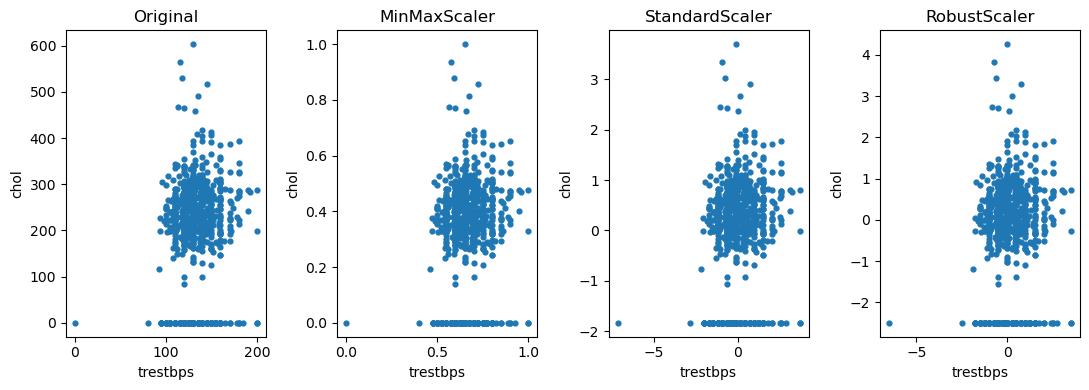

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Scatter avant/après (2 variables)
# Choisir 2 variables numériques 
feat1, feat2 = "trestbps", "chol"   

X2 = X_imputed[[feat1, feat2]].values

# Scalers
X_minmax = MinMaxScaler().fit_transform(X2)
X_std    = StandardScaler().fit_transform(X2)
X_rob    = RobustScaler().fit_transform(X2)

plt.figure(figsize=(11,4))

# Original
plt.subplot(1,4,1)
plt.scatter(X2[:,0], X2[:,1], s=12)
plt.title("Original")
plt.xlabel(feat1); plt.ylabel(feat2)

# MinMax
plt.subplot(1,4,2)
plt.scatter(X_minmax[:,0], X_minmax[:,1], s=12)
plt.title("MinMaxScaler")
plt.xlabel(feat1); plt.ylabel(feat2)

# Standard
plt.subplot(1,4,3)
plt.scatter(X_std[:,0], X_std[:,1], s=12)
plt.title("StandardScaler")
plt.xlabel(feat1); plt.ylabel(feat2)

# Robust
plt.subplot(1,4,4)
plt.scatter(X_rob[:,0], X_rob[:,1], s=12)
plt.title("RobustScaler")
plt.xlabel(feat1); plt.ylabel(feat2)

plt.tight_layout()
plt.show()


**Interprétation (Partie 6)**  
Le nuage de points montre l’effet des trois mises à l’échelle sur `trestbps` et `chol`. **MinMaxScaler** ramène les valeurs dans **[0,1]** mais peut être très sensible aux valeurs extrêmes. **StandardScaler** centre et réduit (autour de 0) mais reste influencé par les outliers. **RobustScaler** (médiane + IQR) réduit mieux l’impact des valeurs atypiques, ce qui est pertinent ici vu la présence de points extrêmes (ex. `chol` très faible).


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_19652\3087956777.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x.ravel(), x_minmax, x_std, x_rob],


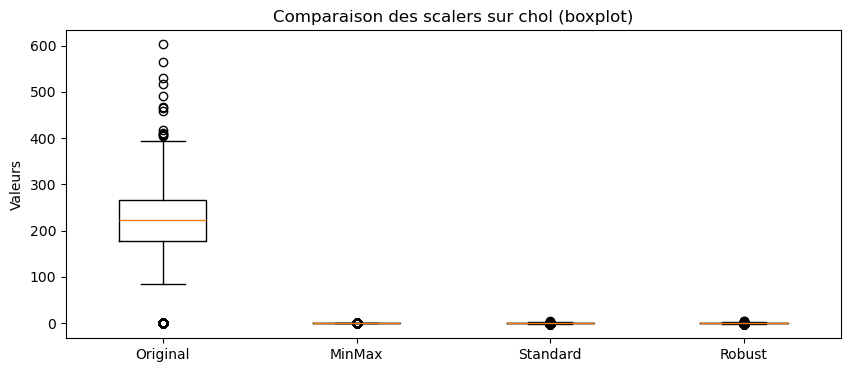

In [174]:
# Boxplot avant/après (même variable)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

var = "chol"  # ou "oldpeak"
x = X_imputed[[var]].values

x_minmax = MinMaxScaler().fit_transform(x).ravel()
x_std    = StandardScaler().fit_transform(x).ravel()
x_rob    = RobustScaler().fit_transform(x).ravel()

plt.figure(figsize=(10,4))
plt.boxplot([x.ravel(), x_minmax, x_std, x_rob],
            labels=["Original", "MinMax", "Standard", "Robust"])
plt.title(f"Comparaison des scalers sur {var} (boxplot)")
plt.ylabel("Valeurs")
plt.show()


**Interprétation (boxplot `chol`)**  
Le boxplot montre que `chol` contient des **valeurs atypiques** (points extrêmes). **MinMaxScaler** compresse toutes les valeurs dans [0,1] et l’échelle est fortement influencée par ces extrêmes. **StandardScaler** centre-réduit mais reste sensible aux outliers. **RobustScaler** (médiane + IQR) réduit davantage l’impact des valeurs extrêmes, ce qui le rend plus adapté ici.



## Partie 7 : Transformation de puissance (PowerTransformer)

### Introduction (PowerTransformer)
Certaines variables numériques sont **asymétriques** et s’éloignent d’une distribution normale, ce qui peut pénaliser certains modèles. **PowerTransformer (Yeo-Johnson)** applique une transformation monotone pour rendre la distribution plus “gaussienne” (et Yeo-Johnson accepte aussi les valeurs négatives). Ici, on l’applique à `oldpeak` sur les données imputées (`X_imputed`) et on compare avant/après.



Skewness original : 1.133
Skewness transformé : -0.352


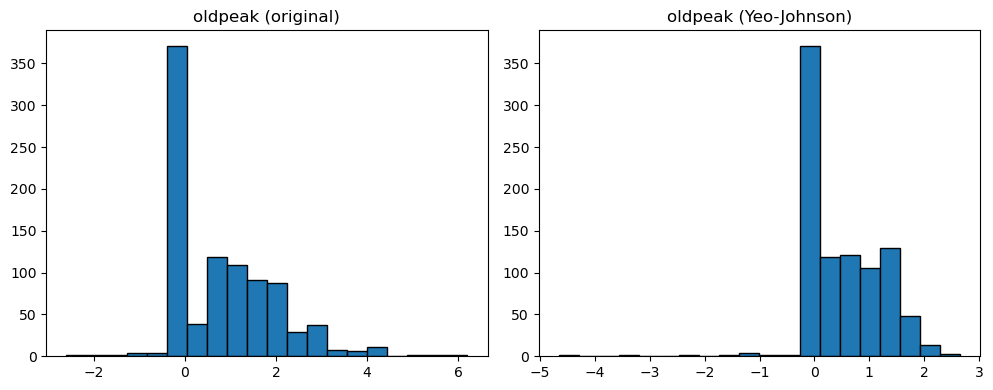

In [177]:

# Transformation Yeo-Johnson sur 'oldpeak'
var = "oldpeak"
x = X_imputed[[var]].values  

# Par défaut, PowerTransformer transforme + standardise (≈ moyenne 0, variance 1).
# Or en Partie 6 tu compares déjà des scalers
pt = PowerTransformer(method="yeo-johnson", standardize=False) 
x_trans = pt.fit_transform(x)

# Calcul du coefficient d'asymétrie (skewness)
print(f"Skewness original : {skew(x.ravel()):.3f}")
print(f"Skewness transformé : {skew(x_trans.ravel()):.3f}")

# Visualisation
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(x.ravel(), bins=20, edgecolor="k")
plt.title(f"{var} (original)")
plt.subplot(1,2,2)
plt.hist(x_trans.ravel(), bins=20, edgecolor="k")
plt.title(f"{var} (Yeo-Johnson)")
plt.tight_layout()
plt.show()


### Interprétation
Après transformation, l’histogramme de `oldpeak` devient plus **symétrique** et l’asymétrie diminue (skewness plus proche de 0), ce qui indique une distribution plus proche de la normale. Cette transformation peut améliorer la stabilité de l’apprentissage en réduisant l’effet des fortes asymétries.

### QQ-plot

Ça montre clairement le “plus proche d’une normale” :

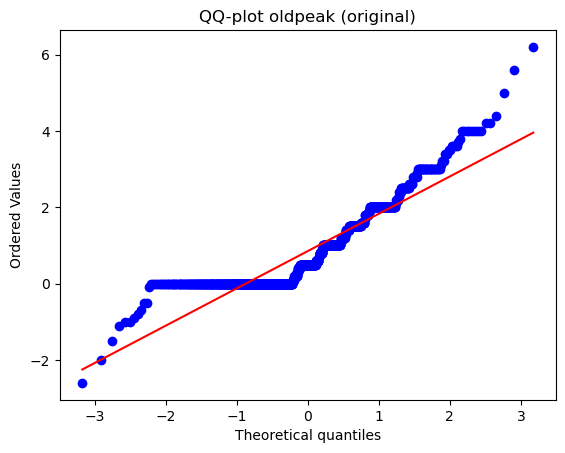

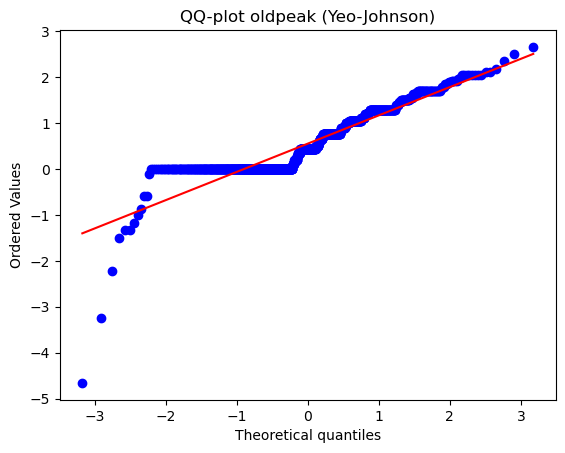

In [180]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(x.ravel(), dist="norm", plot=plt)
plt.title(f"QQ-plot {var} (original)")
plt.show()

stats.probplot(x_trans.ravel(), dist="norm", plot=plt)
plt.title(f"QQ-plot {var} (Yeo-Johnson)")
plt.show()


**QQ-plot (avant/après)**  
Sur le QQ-plot original, les points s’écartent fortement de la droite, ce qui indique que `oldpeak` n’est pas proche d’une loi normale. Après la transformation **Yeo-Johnson**, les points sont globalement plus alignés avec la droite : la distribution devient plus “gaussienne”, surtout au centre (les extrêmes peuvent rester légèrement déviés).



## Partie 8 : PolynomialFeatures (degré 2)

L’objectif est de capturer des relations **non linéaires** et des **interactions** entre variables numériques.  
Nous appliquons `PolynomialFeatures` avec un **degré 2** sur `age`, `trestbps` et `chol`, après mise à l’échelle, afin de générer des termes comme `x²` et `x1*x2`.



In [183]:
# ============================
# Partie 8 : PolynomialFeatures (deg 2) + standardisation
# ============================

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

# 1) Sélection on a limiter à 3 variables pour éviter l'explosion
selected = ["age", "trestbps", "chol"]
X_num = X_imputed[selected]  

# 2) Paramètre demandé
degree = 2  

# 3) Pipeline : scaler -> polynomial 
poly_pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=degree, include_bias=False)
)

# 4) Transformation
X_poly = poly_pipe.fit_transform(X_num)

# 5) Noms des nouvelles variables générées
poly = poly_pipe.named_steps["polynomialfeatures"]
feature_names = poly.get_feature_names_out(selected)

# 6) Résultats : dimension avant/après + liste des variables
print(f"Variables d'origine : {selected}")
print(f"Dimension avant : {X_num.shape[1]}")
print(f"Dimension après PolynomialFeatures (deg {degree}) : {X_poly.shape[1]}")
print("\nNoms des nouvelles caractéristiques :")
print(feature_names)

# 7) Mettre en DataFrame pour inspection + aperçu
X_poly_df = pd.DataFrame(X_poly, columns=feature_names, index=X_imputed.index)
display(X_poly_df.head())


Variables d'origine : ['age', 'trestbps', 'chol']
Dimension avant : 3
Dimension après PolynomialFeatures (deg 2) : 9

Noms des nouvelles caractéristiques :
['age' 'trestbps' 'chol' 'age^2' 'age trestbps' 'age chol' 'trestbps^2'
 'trestbps chol' 'chol^2']


,age,trestbps,chol,age^2,age trestbps,age chol,trestbps^2,trestbps chol,chol^2
0,1.007386,0.705176,0.303643,1.014826,0.710385,0.305886,0.497274,0.214122,0.092199
1,1.432034,1.518569,0.789967,2.050721,2.174643,1.131259,2.306053,1.199620,0.624048
2,1.432034,-0.650479,0.266939,2.050721,-0.931507,0.382266,0.423122,-0.173638,0.071257
3,-1.752828,-0.108217,0.459634,3.072405,0.189685,-0.805659,0.011711,-0.049740,0.211263
4,-1.328180,-0.108217,0.037541,1.764061,0.143731,-0.049862,0.011711,-0.004063,0.001409


### Interprétation / Réponses attendues

- **Degré choisi :** 2 (compromis entre richesse des relations et complexité du modèle).  
- **Nouvelles variables générées :** termes quadratiques et interactions, ex. `age²`, `trestbps²`, `chol²`, `age*trestbps`, `age*chol`, `trestbps*chol`.  
- **Impact sur la dimension :** on passe de **3 variables** à **9 caractéristiques** (augmentation due aux interactions + carrés).  

**Justification :** le degré 2 suffit souvent pour modéliser des non-linéarités simples, tout en limitant l’explosion du nombre de variables et le risque de surapprentissage (contrairement au degré 3).



## Partie 9(10 dans le fichier word) : Pipeline complet (ColumnTransformer + make_pipeline) et modèle de classification


Dans cette étape, on a construit un **pipeline Scikit-Learn complet** afin de rendre le prétraitement et la modélisation **reproductibles** et **sans fuite de données** (tout est appris uniquement sur l’ensemble d’entraînement).  
Le pipeline intègre :
- **Imputation** : médiane pour les variables numériques, valeur la plus fréquente pour les catégorielles ;
- **Encodage** : `slope` en **OrdinalEncoder** (downsloping < flat < upsloping) et les autres variables catégorielles en **OneHotEncoder** (`drop='first'`, `handle_unknown='ignore'`) ;

**Pourquoi `drop='first'` et `handle_unknown='ignore'` ?**

`drop='first'` : supprime la première modalité de chaque variable catégorielle après le One-Hot Encoding afin d’éviter la **redondance** (multicolinéarité / “dummy variable trap”). Les autres colonnes suffisent pour représenter l’information.
`handle_unknown='ignore'` : si une **nouvelle catégorie** apparaît dans les données de test ou en production (jamais vue à l’entraînement), l’encodeur **ne génère pas d’erreur** et encode cette catégorie avec des **0** sur les colonnes correspondantes.

- **Mise à l’échelle** : comparaison de deux variantes sur les numériques (**StandardScaler** vs **RobustScaler**) ;
- **Modèle de classification : `LogisticRegression`**
  - Choisi comme **baseline** simple, rapide et robuste pour la classification.
  - Il donne des résultats **interprétables** (poids/coefficients des variables) et fonctionne bien quand les variables sont **normalisées/standardisées**.
  - Il s’intègre naturellement dans un **Pipeline** (prétraitement + modèle) pour éviter les fuites de données et garder un workflow reproductible.


Enfin, je sépare les données en **train/test** avec `stratify` (permet de conserver **la même proportion de classes** dans `train` et `test` que dans la cible `y`.  
  ➜ Utile quand les classes sont **déséquilibrées**, pour éviter un test set non représentatif et une évaluation biaisée. déjà vérifié lors de la partie 2 comme bonus)

puis j’évalue la performance via l’**accuracy**.

---


In [186]:
# ============================
# Partie 10 : Pipeline complet (make_pipeline + ColumnTransformer)
# Imputation + Encodage + Normalisation/Standardisation + Modèle
# ============================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ----------------------------
# 0) Données
# ----------------------------
# on a déjà :
# numeric_features = ['age','trestbps','chol','thalch','oldpeak','ca']
# categorical_features = ['sex','dataset','cp','fbs','restecg','exang','slope','thal']
# target = 'num'

X = df[numeric_features + categorical_features].copy()
y = df[target].copy()

# Optionnel mais conseillé (au cas où la cible a des NaN)
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

# ----------------------------
# 1) Split (stratify)
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ----------------------------
# 2) Pipelines de prétraitement (cohérents avec tes choix)
# ----------------------------

# a) Numériques : médiane + scaler (Standard OU Robust)
num_pipe_standard = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

num_pipe_robust = make_pipeline(
    SimpleImputer(strategy="median"),
    RobustScaler()
)

# b) Catégorielles :
# - slope = OrdinalEncoder avec l'ordre vu dans ton notebook
# - le reste = OneHotEncoder(drop='first', ignore unknown) + imputation mode

slope_categories = [['downsloping', 'flat', 'upsloping']]
slope_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=slope_categories)
)

nominal_cols = [c for c in categorical_features if c != "slope"]

nominal_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="first", handle_unknown="ignore")
)

# ----------------------------
# 3) ColumnTransformer (standard vs robust)
# ----------------------------
preprocessor_standard = ColumnTransformer(
    transformers=[
        ("num", num_pipe_standard, numeric_features),
        ("slope", slope_pipe, ["slope"]),
        ("nominal", nominal_pipe, nominal_cols)
    ],
    remainder="drop"
)

preprocessor_robust = ColumnTransformer(
    transformers=[
        ("num", num_pipe_robust, numeric_features),
        ("slope", slope_pipe, ["slope"]),
        ("nominal", nominal_pipe, nominal_cols)
    ],
    remainder="drop"
)

# ----------------------------
# 4) Modèle de classification (pour notre choix)
# ----------------------------
clf = LogisticRegression(max_iter=1000)

# ----------------------------
# 5) Pipelines complets (make_pipeline)
# ----------------------------
pipeline_standard = make_pipeline(preprocessor_standard, clf)
pipeline_robust   = make_pipeline(preprocessor_robust, clf)

# ----------------------------
# 6) Entraînement + Évaluation
# ----------------------------
pipeline_standard.fit(X_train, y_train)
pred_standard = pipeline_standard.predict(X_test)
acc_standard = accuracy_score(y_test, pred_standard)

pipeline_robust.fit(X_train, y_train)
pred_robust = pipeline_robust.predict(X_test)
acc_robust = accuracy_score(y_test, pred_robust)

print(f"Accuracy (Pipeline StandardScaler) : {acc_standard:.3f}")
print(f"Accuracy (Pipeline RobustScaler)   : {acc_robust:.3f}")


Accuracy (Pipeline StandardScaler) : 0.598
Accuracy (Pipeline RobustScaler)   : 0.603


### Conclusion — Interprétation des résultats

Les scores obtenus sont :
- **Accuracy (StandardScaler)** = **0.598**
- **Accuracy (RobustScaler)**   = **0.603**

Le pipeline avec **RobustScaler** obtient une accuracy **légèrement supérieure** . Cela est cohérent avec l’analyse précédente : **RobustScaler** est généralement plus stable lorsque certaines variables numériques contiennent des **valeurs extrêmes (outliers)**.  
Cependant, l’écart reste faible : les deux pipelines ont des performances proches, ce qui suggère que la mise à l’échelle n’est pas le seul facteur limitant et qu’une amélioration pourrait venir du **choix du modèle**, des **hyperparamètres** ou d’un meilleur **feature engineering**.
